In [25]:
from copy import copy, deepcopy
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor  
import random

import sklearn.linear_model
import pandas as pd 
import numpy as np
import sys
import re

%matplotlib inline

In [26]:
# Load the Wine Dataset
df_wine = pd.read_csv("df_wine.csv", encoding = 'utf8', index_col=0)

In [27]:
df_wine.head(1)

,price,title,points,year_of_wine,v_Abouriou,v_Aglianico,v_Airen,v_Albana,v_Albanello,v_Albariño,...,province_Spanish Islands,province_Tasmania,province_Texas,province_Tuscany,province_Veneto,province_Vermont,province_Victoria,province_Virginia,province_Washington,province_Western Australia
0,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),87,2013,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preparition

In [28]:
# DEFINE X and Y VARIABLES
df_wine = df_wine[df_wine['year_of_wine'] > 0]
df_X = df_wine.drop('points', axis=1)
df_X = df_X.drop('title', axis=1) # year was already extracted
df_Y = df_wine[['points']]

# Test & Train Split

In [29]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=0) 

# HPO with groundtruth

In [6]:
# Using Randomized Search instead of a grid search

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
regressor3 = DecisionTreeRegressor()
param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs = RandomizedSearchCV(regressor3, 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
clfrs.fit(X_train, y_train)
clfrs.best_params_, clfrs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.2min finished


({'max_depth': 11, 'min_samples_split': 12}, -5.4972439374636455)

# Decision Tree

In [9]:
# Best result with Hyperparameter optimisation
regressor = DecisionTreeRegressor(max_depth=11, min_samples_split=12)  

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regressor.predict(X_test)

# The evaluation metrics
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 1.841139601683168
Mean Squared Error: 5.448613811002482
Root Mean Squared Error: 2.3342265980410906


# Introduce Errors in Testing

In [33]:
# Ground truth for other calculations
X_test_gt = X_test.copy()

In [34]:
X_test[['year_of_wine']].describe()

,year_of_wine
count,29310.000000
mean,2010.666018
std,3.550408
min,1985.000000
25%,2009.000000
50%,2011.000000
75%,2013.000000
max,2017.000000


In [35]:
year = X_train[['year_of_wine']].copy()
year.columns = ['new_year']
# df_wine = pd.concat([year, df_wine], axis=1)
# df_wine

In [36]:
def introduce_outliers(df):
    rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
    # minimum sayi 1940 %0.5 e kadar artabilir
    # max sayi 2018 %0.5 e kadar artabilir
    j = 0
    year_val = 0
    for i, row in df.iterrows():
        if j%2 == 0:
            year_val = row['year_of_wine'] * random.choice(rates)
            df.at[i,'year_of_wine'] = year_val
        j = j + 1
    return df

In [37]:
X_test = introduce_outliers(X_test)

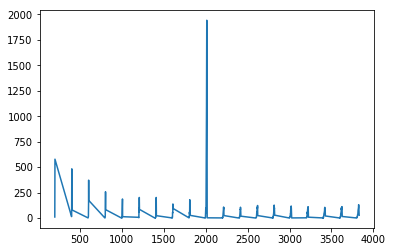

In [38]:
plt.plot(X_test.groupby(['year_of_wine']).size())

# HPO with errors in Testing

In [15]:
# Using Randomized Search instead of a grid search

# combine training and testing
tr_data = pd.concat([X_train, X_test], axis=0)
te_data = pd.concat([y_train, y_test], axis=0)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
regressor3 = DecisionTreeRegressor()
param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs = RandomizedSearchCV(regressor3, 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
clfrs.fit(tr_data, te_data)
clfrs.best_params_, clfrs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.5min finished


({'max_depth': 10, 'min_samples_split': 15}, -5.531594330790843)

# Decision Tree Regressor with Outliers in Testing

In [17]:
# Best result with Hyperparameter optimisation
regressor = DecisionTreeRegressor(max_depth = 10, min_samples_split = 15)  

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regressor.predict(X_test)

# The evaluation metrics
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 1.951533694873603
Mean Squared Error: 6.192778224980914
Root Mean Squared Error: 2.488529329740944


# Outlier Detection

In [18]:
mean = np.mean(X_test[['year_of_wine']], axis=0)
sd = np.std(X_test[['year_of_wine']], axis=0)

In [19]:
def outlier_detection(data):
    mean = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    final_list = [x for x in data if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
    return final_list, mean

In [20]:
year_outliers = outlier_detection(X_test['year_of_wine'].values)[0]
mean = outlier_detection(X_test['year_of_wine'].values)[1]

In [21]:
X_test.head()

,price,year_of_wine,v_Abouriou,v_Aglianico,v_Airen,v_Albana,v_Albanello,v_Albariño,v_Albarossa,v_Aleatico,...,province_Spanish Islands,province_Tasmania,province_Texas,province_Tuscany,province_Veneto,province_Vermont,province_Victoria,province_Virginia,province_Washington,province_Western Australia
84805,48.0,1809,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4507,35.0,2013,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15458,70.0,3820,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57872,17.0,2005,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6460,20.0,403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
min_year = min(year_outliers)
max_year = max(year_outliers)

training_data = pd.concat([X_train, y_train], axis=1)

training_cleaned = training_data.drop(training_data[training_data.year_of_wine < min_year].index)
training_cleaned = training_cleaned.drop(training_cleaned[training_cleaned.year_of_wine > max_year].index)

X_train_outlier_cleaned = training_cleaned[training_cleaned.columns[:-1].tolist()]
y_train_outlier_cleaned = training_cleaned['points'].values.reshape(-1, 1)

In [23]:
min_year = min(year_outliers)
max_year = max(year_outliers)

testing_data = pd.concat([X_test, y_test], axis=1)

testing_cleaned = testing_data.drop(testing_data[testing_data.year_of_wine < min_year].index)
testing_cleaned = testing_cleaned.drop(testing_cleaned[testing_cleaned.year_of_wine > max_year].index)

X_test_outlier_cleaned = testing_cleaned[testing_cleaned.columns[:-1].tolist()]
#y_test_outlier_cleaned = testing_cleaned['points'].values.reshape(-1, 1)
y_test_outlier_cleaned = testing_cleaned.filter(['points'], axis=1)

# PRECISION & RECALL & RMSE FOR ERRORS

# HPO with cleaned data

In [24]:
# Using Randomized Search instead of a grid search

# combine training and testing
tr_data = pd.concat([X_train, X_test_outlier_cleaned], axis=0)
te_data = pd.concat([y_train, y_test_outlier_cleaned], axis=0)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
regressor3 = DecisionTreeRegressor()
param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs = RandomizedSearchCV(regressor3, 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
clfrs.fit(tr_data, te_data)
clfrs.best_params_, clfrs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished


({'max_depth': 10, 'min_samples_split': 15}, -5.539306951464277)

# Decision Tree Regressor with Cleaned Data

In [46]:
# Best result with Hyperparameter optimisation
regressor = DecisionTreeRegressor(max_depth=9, min_samples_split=10)  

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regressor.predict(X_test_outlier_cleaned)

# The evaluation metrics
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_outlier_cleaned, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_outlier_cleaned, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_outlier_cleaned, y_pred))) 

Mean Absolute Error: 1.9270191555857648
Mean Squared Error: 6.0285675817265725
Root Mean Squared Error: 2.455314151331062
